In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mt
from metpy.interpolate import interpolate_to_points
import scipy.optimize as spo

In [2]:
# creating the pulse field

def gen_field(dur_max, dur_step):
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_j, ppau_j = np.meshgrid(pdur_i0, ppau_i0)
    return pdur_j, ppau_j


In [3]:
#Importing data from file

def import_data():
    df = pd.read_excel('dat/anuro_ppf.xls', sheet_name='PPF_margins', usecols='A:J')

    pdur = df['PDUR'].values
    ppau = df['PPAU'].values
    phonotaxis = df['rXY'].values

    dur_max = 20  # ms
    dur_step = 0.5  # ms

    # need to jitter data points slightly for interp to work - probably a bug in metpy
    points = np.array([pdur + np.random.randn(*pdur.shape)/100, ppau + np.random.randn(*ppau.shape)/100]).T
    

    # make new grid of points to interpolate to
    pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
    pdur_i, ppau_i = np.meshgrid(pdur_i0, ppau_i0)
    new_points = np.array([pdur_i, ppau_i]).T.reshape((-1, 2))
    
    # natural neighbour interpolation 
    ppf = interpolate_to_points(points, phonotaxis, new_points, interp_type='natural_neighbor')
    ppf[np.isnan(ppf)] = np.nanmean(ppf)
    ppf = np.maximum(ppf, 0)  # set neg vals to 0
    ppf = ppf.reshape((len(pdur_i), len(ppau_i))).T  # make interpolated ppf square
    # print(np.any(np.isnan(new_points)))
    
    ppf /= np.max(ppf)
    
    return ppf

In [13]:
dur_max = 20  # ms
dur_step = 0.5  # ms
global pnt_ori, pdur_i, ppau_i
pnt_ori = import_data()
pnt_ori /= np.max(pnt_ori)
# print(pnt_ori)
pdur_i, ppau_i = gen_field(dur_max, dur_step)

In [14]:
#generating the signal from the parameter duty cycle

def signal(idur, ipau, sf):
    sf = int(sf)
    unit = (sf/1000)
    dur = int(unit*idur)
    pau = int(unit*ipau)
    #print(dur, pau, unit)
    adur = np.ones(dur, dtype = int)
    apau = np.zeros(pau, dtype = int)
    aper = np.concatenate((adur,apau))
    sig2 = np.tile(aper, sf)
    if len(sig2)>sf:
        sig = sig2[0:sf]
    else:
        l = sf - len(sig2)
        sig3 = np.zeros(l, dtype = int)
        sig = np.concatenate((sig2, sig3))
    return sig

In [15]:
#The Gabor filter

def gabor(fr, sigma, phi, w):
    border = sigma + int(1/sigma)
    t =  np.arange(-border, border, 1)/1000
    gbr = ((np.exp( -(t/2*sigma)**2)) * (np.sin((2*mt.pi*fr*t) + phi)) + w) #Gabor function
    return gbr

# def gabor(fr, sigma, phi, w):
#     border = sigma + int(2000/sigma)
#     time =  range(-100, 100)
#     gbr = []
#     for i in time:
#         t = i/1000 # to get time in milliseconds
#         gbr.append((mt.exp( -((t*sigma)/mt.sqrt(2))**2)) * (np.sin((2*mt.pi*fr*t) + phi)) + w) #Gabor function
#     return gbr

# gaba = gabor(50, 40, 0, 0.1)
# print(np.isnan(gaba))
# plt.plot(gaba)
# plt.show()

In [16]:
#linear nonlinear filtering (including the integration)

def lin_nonlin(sig, gab, a1, b1):
    f1 = np.convolve(sig, gab) #linear filter
    
    g1 = 1/(1 + np.exp( -(a1 * f1) + b1)) # nonlinear sigmoid function

    #integral (which is basically summation)
    v1 = 0.001 * g1.sum()
    return v1

In [17]:
#extracting Phonotaxis value by pushing fabricated signal through filter

def phonotaxis(fr, sigma, phi, w, a1, b1, sf, t1, t2):
    sig1 = signal(t1, t2, sf)
    gab1 = gabor(fr, sigma, phi, w)
    phntxs = lin_nonlin(sig1, gab1, a1, b1)
    return phntxs


In [51]:
def plot_field(pdur_i, ppau_i, res):
    plt.pcolor(pdur_i, ppau_i, res, cmap='Reds')
    plt.xlim(0, np.max(pdur_i))
    plt.ylim(0, np.max(ppau_i))
    plt.colorbar(label='Phonotaxis')
    plt.xlabel('Pulse [ms]')
    plt.ylabel('Pause [ms]')
    plt.show()

In [76]:
#the entire thing a a function

def wholedamnthing(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    # new_points = np.array([pdur_i, ppau_i]).T.reshape((-1, 2))
    #pulse pause field sampling range and frequency(step)
    dur_max = 20  # ms
    dur_step = 0.5  # ms
    #generate field
    sf = 2000
    
    # pdur_i, ppau_i = gen_field(dur_max, dur_step)
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    # plot_field(pnt, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    pnt = (pnt - np.min(pnt))/np.max(pnt)
    
    #RMS of difference
    diff = np.mean((pnt - pnt_ori)**2)
    
    print(pnt.shape, pnt_ori.shape, diff)
#     print('ori nan')
#     print(np.any(np.isnan(pnt_ori)))
#     print(np.sum(np.isnan(pnt_ori)))
    
    plot_field(pdur_i, ppau_i, pnt)
    
    # return diff


In [83]:
#the entire thing a a function

def wholedamnthing2(cfg):
    fr, sigma, ph, w, a1, b1 = cfg #unpacking the command from gods
    phi = np.pi * ph

    #generate field
    sf = 2000
    
    #calculating phonotaxis values
    phono = np.vectorize(phonotaxis)
    pnt = phono(fr, sigma, phi, w, a1, b1, sf, pdur_i, ppau_i)
    
    #normalization
    pnt = np.maximum(pnt, 0)
    pnt = (pnt - np.min(pnt))/np.max(pnt)
    
    #RMS of difference
    diff = np.mean((pnt - pnt_ori)**2)
    
    return diff


In [87]:
cfg = [50, 50, 0, 0, 0.05, 1]

wholedamnthing2(cfg)

0.031874758462786985

In [3]:
# #parameters for signal generation
# sf = 2000

# #PARAMETERS OF GABOR FUNCTION
# #frequency for the Gabor filter - INFLUENCES pulse period preference
# fr = 50
# #sharpness of tuning for pulse period
# sigma = 50 
# #phase shift - change the integer to change the phase 
# phi = np.pi * 0 
# #offset - INFLUENCES duty cycle preference
# w = 0

# #parameters for Lin_nonlinear
# a1 = 0.05 #slope/steepness of sigmoid
# b1 = 1 #1/2 of max of non linearity

# #pulse pause field sampling range and frequency(step)
# dur_max = 20  # ms
# dur_step = 0.5  # ms

In [76]:
#bounds

b_fr = (30, 70)
b_sigma = (30, 100)
b_phi = (0, 2)
b_w = (-0.1, 0.1)
b_a1 = (0, np.inf)
b_b1 = (-np.inf, np.inf)

bnds = (b_fr, b_sigma, b_phi, b_w, b_a1, b_b1) #, b_dur_max, b_dur_step) #if necessary 


In [5]:
#constraints

c_sf = {'type' : 'eq', 'fun' : lambda sf: sf%1000}
c_a1 = {'type' : 'ineq', 'fun' : lambda a1: a1}

cons = (c_sf, c_a1)

In [6]:
#what should I return from the function (parameter to be maximised.
#Constraints and boundaries of each parameter

In [7]:
res = spo.minimize(wholedamnthing, cfg, options = {"disp": True},  bounds = bnds)

if result.success:
    print("Success!")
    plot_field(pdur_i, ppau_i, res)
else:
    print("Sorry, could not find a minimum.")

NameError: name 'wholedamnthing' is not defined

0.7822569775480468


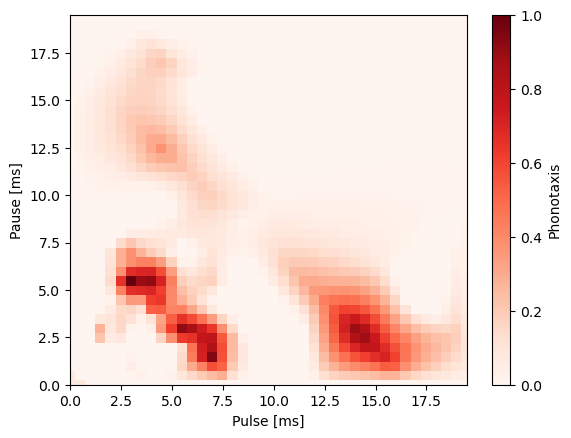

In [63]:
df = pd.read_excel('dat/anuro_ppf.xls', sheet_name='PPF_margins', usecols='A:J')

pdur = df['PDUR'].values
ppau = df['PPAU'].values
phonotaxis = df['rXY'].values

dur_max = 20  # ms
dur_step = 0.5  # ms

# need to jitter data points slightly for interp to work - probably a bug in metpy
points = np.array([pdur + np.random.randn(*pdur.shape)/100, ppau + np.random.randn(*ppau.shape)/100]).T


# make new grid of points to interpolate to
pdur_i0 = ppau_i0 = np.arange(0, dur_max, dur_step)
pdur_i, ppau_i = np.meshgrid(pdur_i0, ppau_i0)
new_points = np.array([pdur_i, ppau_i]).T.reshape((-1, 2))

# natural neighbour interpolation 
ppf = interpolate_to_points(points, phonotaxis, new_points, interp_type='natural_neighbor')
ppf[np.isnan(ppf)] = np.nanmean(ppf)
ppf = np.maximum(ppf, 0)  # set neg vals to 0
ppf = ppf.reshape((len(pdur_i), len(ppau_i))).T  # make interpolated ppf square


y = np.max(ppf)

ppf1 = ppf * (1/y)
print(y)


plot_field(ppf1, pdur_i, ppau_i)
# print(np.any(np.isnan(new_points)))


In [46]:
np.nanmean(ppf, axis=0)

0.05812436819297596

In [47]:
ppf

array([        nan,         nan,         nan, ..., -0.00203503,
       -0.00227538, -0.0014385 ])

In [52]:
ppf[np.isnan(ppf)] = np.nanmean(ppf)
# /np.nanmean(ppf, axis=0)

In [53]:
ppf

array([ 0.05812437,  0.05812437,  0.05812437, ..., -0.00203503,
       -0.00227538, -0.0014385 ])

[[ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.5  0.5  0.5 ...  0.5  0.5  0.5]
 [ 1.   1.   1.  ...  1.   1.   1. ]
 ...
 [18.5 18.5 18.5 ... 18.5 18.5 18.5]
 [19.  19.  19.  ... 19.  19.  19. ]
 [19.5 19.5 19.5 ... 19.5 19.5 19.5]] [[ 0.   0.5  1.  ... 18.5 19.  19.5]
 [ 0.   0.5  1.  ... 18.5 19.  19.5]
 [ 0.   0.5  1.  ... 18.5 19.  19.5]
 ...
 [ 0.   0.5  1.  ... 18.5 19.  19.5]
 [ 0.   0.5  1.  ... 18.5 19.  19.5]
 [ 0.   0.5  1.  ... 18.5 19.  19.5]] [[0.07564551 0.07564551 0.         ... 0.0005279  0.00066963 0.00069509]
 [0.07564551 0.         0.         ... 0.06927471 0.05230508 0.03944181]
 [0.07564551 0.         0.         ... 0.13172884 0.09843885 0.07375462]
 ...
 [0.07564551 0.         0.         ... 0.         0.         0.        ]
 [0.07564551 0.         0.         ... 0.         0.         0.        ]
 [0.07564551 0.         0.         ... 0.         0.         0.        ]]
